# Laboratorio 7 (Segmentación de Clientes de Banco) - Inteligencia Artificial
Autores: Stefano Aragoni, Carol Arévalo, Luis Santos

_________

En este caso, se tiene un dataset en el cual se desea analizar la segmentación de clientes de un banco. Es dataset provisto contiene información de diferentes trasacciones realizadas por clientes. Del cliente, tenemos información como su fecha de nacimiento, género, ubicación, dinero actual en su cuenta, así como la cantidad de dinero involucrada en la respectiva transacción.

A continuación se presenta cómo se utilizó K-Means para poder hacer la agrupación de clientes según diferentes características provistas por el dataset.

_____________

### Task 1.0: Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [24]:
# Importar librerías 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Cargar el dataset
data = pd.read_csv('bank_transactions.csv')

data.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


##### Datos Faltantes
En este caso, se encontró que CustomerDOB contaba con datos faltantes. Por tal razón, posteriormente se utilizó un método para poder rellenar dichos datos faltantes.

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'], dtype='object')

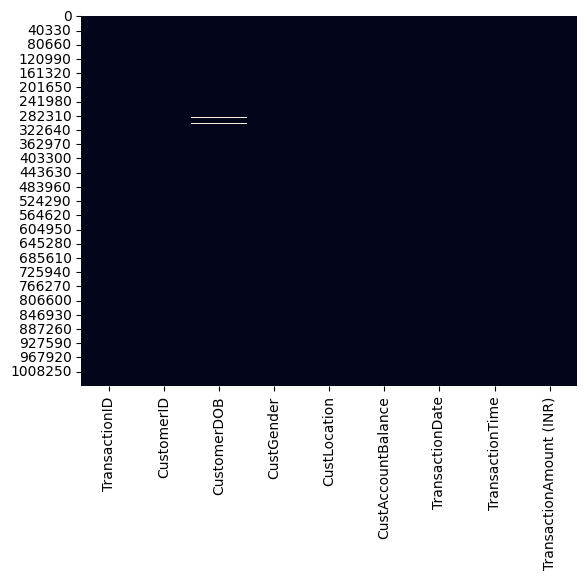

In [25]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

En caso hayan datos faltantes que no se pueden observar en la gráfica, a continuación se realizó un proceso que rellena datos faltantes con promedio de datos.

In [26]:
for col in data.columns[data.isnull().any()]:

    if data[col].dtype == 'float64' or data[col].dtype == 'int64':
        data[col].fillna(data[col].mean(), inplace=True)

    else:
        data[col].fillna(data[col].mode()[0], inplace=True)

data.columns[data.isnull().any()]

Index([], dtype='object')

##### Encoding
Convertir variables que no son numéricas a numéricas. En este caso, principalmente se estaba conviertiendo fecha de nacimiento a edad. Se mapeó género a 0 o 1, correspondiente a M y F. Por otro lado, se eliminaron variables de ID, ya que no presentan información útil para la clasificación de clientes; solo son identificadores únicos.

In [27]:
import datetime
from datetime import timedelta, date
from sklearn.preprocessing import LabelEncoder

#-------------------EDAD-------------------------
# Convertir CustomerDOB a año de nacimiento
data['YOB'] = '19' + data['CustomerDOB'].str[-2:]
data['YOB'] = data['YOB'].astype(int)

# Eliminar columna de DOB
data = data.drop(['CustomerDOB'], axis=1)

# Determinar edad
data['Age'] = 2023 - data['YOB']

# Eliminar columna de YOB
data = data.drop(['YOB'], axis=1)

#-------------------GENERO-------------------------
# Convertir genero a int. M = 0, F = 1
data['CustGender'] = data['CustGender'].map({'M': 0, 'F': 1})

#------------ELIMINAR TRANSACTIONS----------------
data = data.drop(['TransactionID'], axis=1)

#-----------------ELIMINAR CID--------------------
data = data.drop(['CustomerID'], axis=1)

#----------ELIMINAR VARIABLES QUE NO DAN INFO DE CLIENTE --------------
data = data.drop(['TransactionDate'], axis=1)
data = data.drop(['TransactionTime'], axis=1)

data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age
0,1.0,JAMSHEDPUR,17819.05,25.0,29
1,0.0,JHAJJAR,2270.69,27999.0,66
2,1.0,MUMBAI,17874.44,459.0,27
3,1.0,MUMBAI,866503.21,2060.0,50
4,1.0,NAVI MUMBAI,6714.43,1762.5,35


In [28]:
# Convierte la ubicacion a un numero
le = LabelEncoder()
data["CustLocation"] = le.fit_transform(data["CustLocation"])

data.head()

,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),Age
0,1.0,3586,17819.05,25.0,29
1,0.0,3648,2270.69,27999.0,66
2,1.0,5268,17874.44,459.0,27
3,1.0,5268,866503.21,2060.0,50
4,1.0,5657,6714.43,1762.5,35


##### Balanceo
Se determino que es importantes que la siguiente variable esté balanceada:

-CustGender: para verificar que exista una cantidad equilibrada de datos para ambos géneros


In [29]:
data2 = data.copy()

In [30]:
from imblearn.over_sampling import SMOTE

#Calcular cuantas columans son F y cuantas M en CustGender
print('Número de F:',data2[data2['CustGender'] == 1].shape[0])
print('Número de M:',data2[data2['CustGender'] == 0].shape[0])
data2 = data2.dropna(subset=['CustGender'])

# Separar las características y la variable objetivo
X_temp = data2.drop('CustGender', axis=1)
y_temp = data2['CustGender']

#Aplicar SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)

data2 = pd.concat([X_resampled, y_resampled], axis=1)

# Contar los valores de cada clase
print('Número de F balanceado:',data2[data2['CustGender'] == 1].shape[0])
print('Número de M balanceado:',data2[data2['CustGender'] == 0].shape[0])



Número de F: 281936
Número de M: 766630
Número de F balanceado: 766630
Número de M balanceado: 766630


##### Escalar
En este caso, se utilizó la librería de SKLearn para poder escalar y normalizar los datos que lo necesitaran. Asimismo, también se hizo un análisis pre y post escalamiento para determinar la distribución de los datos. En el preprocesamiento, se podía observar cómo ciertas variables tenían una alta desviación estándar a comparación de su respectiva media. Esto fue solucionado a través de la función de MinMaxScaler(). 

> Asimismo, es importante mencionar que la normalización de datos es importante para, según Microsoft, "tener datos que usan una escala común, sin distorsionar las diferencias en los intervalos de valores ni perder información". https://learn.microsoft.com/es-es/azure/machine-learning/component-reference/normalize-data

In [31]:
# Calcular media y desviación estándar de cada columna
print('\n\nMedia y desviación estándar de cada columna:')
data2.describe()



Media y desviación estándar de cada columna:


,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,CustGender
count,1.533260e+06,1.533260e+06,1.533260e+06,1.533260e+06,1533260.0
mean,4.097742e+03,1.137135e+05,1.593422e+03,4.201457e+01,0.5
std,2.356676e+03,8.462425e+05,6.343204e+03,2.007528e+01,0.5
min,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.0
25%,2.075000e+03,5.283887e+03,1.790000e+02,3.200000e+01,0.0
50%,4.011000e+03,1.808956e+04,4.932570e+02,3.600000e+01,0.5
75%,5.792000e+03,6.109668e+04,1.270272e+03,4.200000e+01,1.0
max,9.354000e+03,1.150355e+08,1.560035e+06,1.230000e+02,1.0


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data2)
df_feat = pd.DataFrame(scaled_features, columns=data2.columns)
df_feat.head()

,CustLocation,CustAccountBalance,TransactionAmount (INR),Age,CustGender
0,0.383365,0.000155,0.000016,0.050505,1.0
1,0.389994,0.000020,0.017948,0.424242,0.0
2,0.563182,0.000155,0.000294,0.030303,1.0
3,0.563182,0.007532,0.001320,0.262626,1.0
4,0.604768,0.000058,0.001130,0.111111,1.0


##### Selección de Variables

Finalmente, se quiso determinar los 2 features que se estarían utilizando para la realización del modelo de agrupación. En este caso, se quería dividir los clientes de un banco en grupos, para así entender la distribución de los mismos. En este caso, sí o sí se quería utilizar como variable CustAccountBalance; ya que es de interés del banco saber qué grupos de personas tienen la mayor cantidad de dinero en el mismo. 

Por otro lado, otra variable de interés era la edad, para así poder entender cómo el dinero del banco está distribuido entre las personas. 

Cabe destacar que se hizo un análisis de correlación, sin embargo, se pudo determinar que no existe mucha correlación entre las mismas. El top de variables con más correlación a CustAccountBalance son:

1. Age                
2. TransactionAmount (INR)                    

En este caso se utilizará CustAccountBalance, Age y TransactionAmount (INR).


> Sin embargo, para las gráficas únicamente se estará escogiendo CustAccountBalance y Age ya que son las variables que nos permitirán hacer la mejor subidivisión de los grupos basado en cómo está distribuído el dinero por edades. 

In [33]:
# Correlación entre las columnas y el status, valores absolutos
corr = df_feat.corr()['CustAccountBalance'].abs().sort_values(ascending=False)
print(corr)

X = df_feat[['Age', 'CustAccountBalance', 'TransactionAmount (INR)']].values

CustAccountBalance         1.000000
Age                        0.094596
TransactionAmount (INR)    0.055483
CustGender                 0.004427
CustLocation               0.002297
Name: CustAccountBalance, dtype: float64


----------
#### K - Means

> 1. Si considera necesario haga split del dataset como en los laboratorios anteriores. Recuerde que es un problema de aprendizaje no supervisado

En este caso, no se hizo split del dataset ya que no se tiene un problema de aprendizaje supervisado. Es decir, que no se está comprobando que el modelo realizado sepa clasificar datos. Simplemente se quiere crear agrupaciones de los clientes del banco.



> 2. Seleccione el número de clusters que mejor se adapte al dataset. Justifique su elección

Se utilizó la Gráfica de "Elbow" en ambos casos (K-Means manual y de SKLearn) para determinar el punto donde se estabiliza el WSS (o Within-Cluster Sum of Squares). Este punto donde se estabiliza dicho valor es conocido como el "codo" de una gráfica. A través de este procedimiento, en ambos casos, se determinó que la mejor cantidad de número de clusters era 3. Como resultado, se envió este parámetro con los modelos.



> 3. Investigue sobre Principal Component Analysis (PCA) y responda: ¿Cómo podría ayudarle a mejorar la calidad de sus clusters?

Principal Component Analysis es una técnica que permite analizar datasets muy grandes y reducir su dimensionalidad. Esto se logra transformando la información a un sistema lineal de cordenadas que describe la mayor cantidad posible de la información original. Esto puede ayudar a mejorar la cantidad de nuestros clusters disminuyendo la cantidad de filas que se encuentran en el dataset, sin perder información importante para este.



> 4. Muestre al menos una gráfica que muestre cómo se dividen los clusters seleccionados. *Seleccione dos features, justifique su elección*

En este caso se crearon 2 gráficas, una para K-Means manual y otra para SKLearn. En ambos casos, se puede observar que se dividen los datos y cómo se crearon los respectivos clusters. 

Para crear dichas gráficas... primero se determinó qué variables tenían mayor correlación con Customer Account Balance; ya que en realidad esa es la variable de más interés para un banco (¿quién tiene más dinero?). Como resultado, se determinó que Age y Transaction Amount eran las variables que más correlación tenían. Por lo cual se utilizaron estas dos en los respectivos modelos además de Customer Account Balance.

Sin embargo, de estas tres variables únicamente se gráfico únicamente **Age** y **CustomerAccountBalance** ya que estas son las que proveen información que permite realizar agrupaciones relacionadas al cliente. Esto a diferencia de CustomerAccountBalance y TransactionAmount, que no nos dicen mucho sobre los tipos de clientes. 

En ambas graficas se muestra la relación entre **Customer Account Balance** y **Age**, esto con la intención de poder determinar cómo está distribuído el dinero en el banco y cuáles son los posibles tipos de cliente. En este caso se pudo observar 3 grupos principales; el primero es de los más jóvenes con menos dinero, el segundo es de adultos con más dinero, y por último tenemos a personas mayores con más dinero que los jóvenes pero menos dinero que los adultos. 

*Creemos que las gráficas son muy buenas indicadoras de cuándo personas empiezan y terminan de trabajar, debido a la cantidad de ingresos y dinero que tienen.*


> 5. Provea una métrica de desempeño, justificando su elección

Se decidió utilizar el índice de Davies–Bouldin, ya que este permite calificar que tan bien se dividieron los clusters de los algoritmos. Esto nos permitió validar el correcto funcionamiento de los clusters de ambos módelos creados.

--------------

### Task 1.1: Implementacion de K-Means
En esta primera sección, se creó manualmente las funciones correspondientes para el funcionamiento del modelo de K-Means

In [34]:
#modelo K-means

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
import pandas as pd

def initialize_centroids(X, K):
    # Inicializar los centroides al azar a partir de los puntos de datos
    centroids = X[np.random.choice(X.shape[0], K, replace=False), :]
    return centroids

def assign_clusters(X, centroids):
    # Asignar cada punto de datos al clúster más cercano
    distances = np.sqrt(np.sum((X - centroids[:, np.newaxis])**2, axis=2))
    cluster_assignments = np.argmin(distances, axis=0)
    return cluster_assignments

def update_centroids(X, cluster_assignments, K):
    # Calcular nuevos centroides a partir de los puntos de datos en cada clúster
    centroids = np.zeros((K, X.shape[1]))
    for i in range(K):
        centroids[i,:] = np.mean(X[cluster_assignments == i, :], axis=0)
    return centroids

def kmeans(X, K, max_iters=100):
    centroids = initialize_centroids(X, K)
    for i in range(max_iters):
        cluster_assignments = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, cluster_assignments, K)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_assignments

Posteriormente, se utilizó la función de calculate_WSS para determinar la métrica de WSS de diferentes modelos con distintos valores de clusters. Esto con el propósito de determinar cuántos clusters son los ideales para este modelo.


Al hacer la gráfica "elbow" (codo) se puede determinar que con 3 clusters empieza a normalizarse el WSS y ya no decrece a una velocidad tan rápida. Por tal razón, el modelo final utilizará 3 clusters. 

k: 1 cost: 63130.55182931728
k: 2 cost: 11250.26230991394
k: 3 cost: 4434.139155957023
k: 4 cost: 2440.2135809269184
k: 5 cost: 1590.900704338808
k: 6 cost: 1099.1256780437068
k: 7 cost: 1061.6292851167502
k: 8 cost: 799.1705203828863


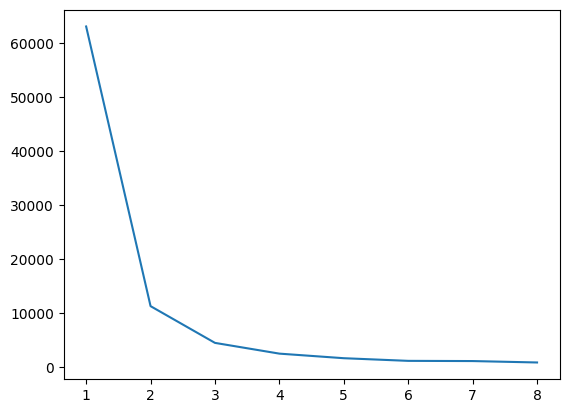

In [35]:
# Determinar la mejor cnatidad de clusters a través de Within-Cluster Sum of Squares (WSS) 
def calculate_WSS(points, kmax=10):
  sse = []
  for k in range(1, kmax+1):
    centroids, cluster_assignments = kmeans(points, k)
    curr_sse = 0
    
    # equivalente a inertia en sklearn
    for i in range(len(points)):
      curr_center = centroids[cluster_assignments[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    print("k:",k, "cost:", curr_sse)
    sse.append(curr_sse)

  return sse

sse = calculate_WSS(X, kmax=8)

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1,9))
ax.plot(x_plot, sse)

En base al valor de K determinado anteriormente, se creó una gráfica para poder demostrar las agrupaciones realizadas por el modelo.

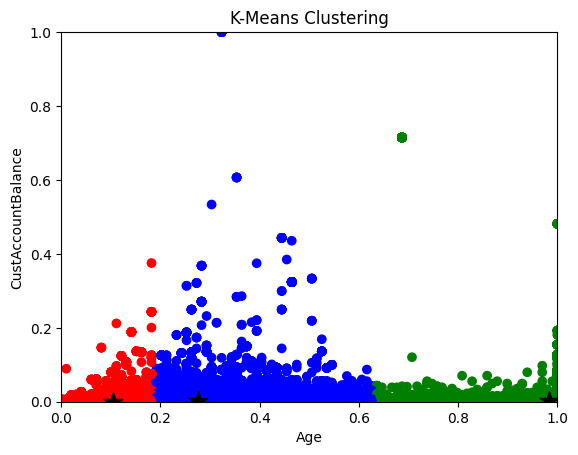

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calcular los centroides y los índices de asignación de clúster
# X Contiene las variables con mayor correlación a CustAccountBalance. i.e. Age, CustAccountBalance, TransactionAmount (INR)...
centroids, cluster_assignments = kmeans(X, K=3) 

fig = plt.figure()
ax = fig.add_subplot(111)

# Assign different colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'b']
cluster_colors = [colors[i] for i in cluster_assignments]

# Plot the data points
ax.scatter(df_feat['Age'], df_feat['CustAccountBalance'], c=cluster_colors)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200)

# Set the axis labels
ax.set_xlabel('Age')
ax.set_ylabel('CustAccountBalance')
ax.set_title('K-Means Clustering')

ax.set_xlim([min(df_feat['Age']), max(df_feat['Age'])])
ax.set_ylim([min(df_feat['CustAccountBalance']), max(df_feat['CustAccountBalance'])])

plt.show()

Para finalizar con el análisis del modelo creado manualmente, se quizo determinar la validez del modelo a través de Davies-Bouldin Index. A continuación, como se puede observar, se obtuvo un valor de aproximadamente 0.44. 

Esto es bueno, ya que mientras más bajo es este valor, mejor es la separación entre los clusters. Cabe destacar que el valor máximo promedio de este índice es entre 2 a 3 (pero podría llegar hasta el infinito positivo), por lo cual este valor cercano a 0 es casi que excelente. 

In [37]:
# Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(X, cluster_assignments))

0.4357764899969614


----------
### Task 1.2: K-Means (SKLEARN - CON PCA)

Como segundo paso, se quiso comparar el resultado del modelo manual con el resultado de K-Means de SKLearn en conjunto con PCA. 


En este caso, también se estará haciendo uso de WSS para calcular cuál es el número de clusters ideal. A través de la gráfica de codo, se podrá determinar dicho valor.
Como se pued observar a continuación, dicho valor sería 3 nuevamente. Esto ya que es este punto en la gráfica de codo cuando empieza a estabilizarse el valor de WSS.


> Cabe destacar que, a pesar de que se usó PCA, no se observa mucha diferencia entre los modelos.

> En este caso se cree que PCA no tuvo mucho impacto ya que únicamente se contaba con 3 features principales, de las cuales se graficaron 2. Por tal razón, PCA no tuvo que quitar muchas características irrelevantes o redundantes, ya que no había mucho ruido en el conjunto de features mandado al modelo. Como resultado, se obtuvo casi el mismo resultado (aunque el modelo de SKLearn presentó un mejor resultado)

k: 1 cost: 63130.8959912802
k: 2 cost: 11250.492012735267
k: 3 cost: 4434.2555787269675
k: 4 cost: 2440.2956521715055
k: 5 cost: 1605.3183356876207
k: 6 cost: 1083.2607827778425
k: 7 cost: 878.0854023041743
k: 8 cost: 658.360688290786


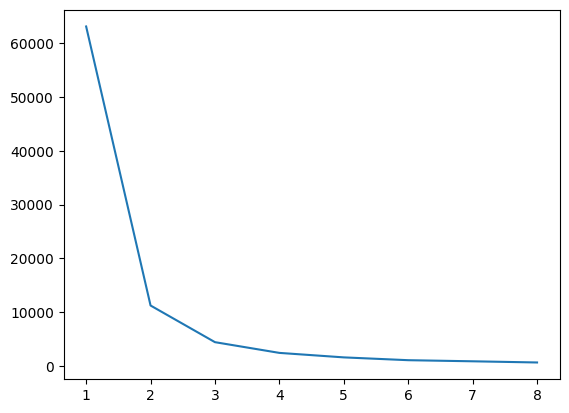

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Determinar la mejor cnatidad de clusters a través de Within-Cluster Sum of Squares (WSS) 
def calculate_WSS(points, kmax=10):
  sse = []

  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init='auto').fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
    print("k:",k, "cost:", curr_sse)

  return sse


# PCA implementation
pca = PCA(n_components=2)
pca.fit(X)
pca_data = pca.transform(X)

# Grafica de codo
sse = calculate_WSS(pca_data, kmax=8)

fig = plt.figure()
ax = plt.axes()

x_plot = list(range(1,9))
ax.plot(x_plot, sse)

c:\Users\carev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


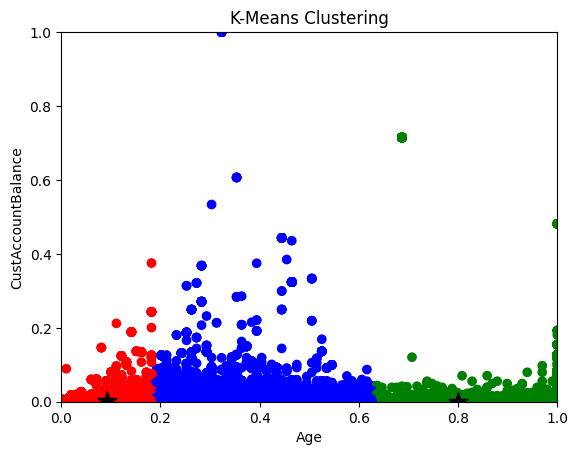

In [39]:
# Calcular los centroides y los índices de asignación de clúster
kmeans = KMeans(n_clusters=3, random_state=0).fit(pca_data)
centroids = kmeans.cluster_centers_
cluster_assignments = kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111)

# Assign different colors to each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'b']
cluster_colors = [colors[i] for i in cluster_assignments]

# Plot the data points
ax.scatter(df_feat['Age'], df_feat['CustAccountBalance'], c=cluster_colors)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200)

# Set the axis labels
ax.set_xlabel('Age')
ax.set_ylabel('CustAccountBalance')
ax.set_title('K-Means Clustering')

ax.set_xlim([min(df_feat['Age']), max(df_feat['Age'])])
ax.set_ylim([min(df_feat['CustAccountBalance']), max(df_feat['CustAccountBalance'])])

plt.show()

Para finalizar con el análisis del modelo creado manualmente, se quizo determinar la validez del modelo a través de Davies-Bouldin Index. A continuación, como se puede observar, se obtuvo un valor de 0.42. 

Esto es bueno, ya que mientras más bajo es este valor, mejor es la separación entre los clusters. Cabe destacar que el valor máximo promedio de este índice es entre 2 a 3 (pero podría llegar hasta el infinito positivo), por lo cual este valor cercano a 0 es casi que excelente. 

In [40]:
# Davies-Bouldin Index
print(davies_bouldin_score(X, cluster_assignments))

0.4357764899969614


### Task 2.1: Implementacion de Mixture Models

In [41]:
import numpy as np
from scipy.stats import norm

def gaussian_mixture(X, n_components, max_iter=100, tol=1e-6):
    n_samples, n_features = X.shape

    # Inicialización aleatoria de las medias y desviaciones estándar
    means = np.random.rand(n_components, n_features)
    stds = np.random.rand(n_components, n_features)

    # Inicialización uniforme de las probabilidades de clase
    class_probs = np.ones(n_components) / n_components

    # Algoritmo EM para estimar los parámetros del modelo
    for i in range(max_iter):
        # E-step: calcular las responsabilidades
        responsibilities = np.zeros((n_samples, n_components))
        for j in range(n_components):
            responsibilities[:, j] = class_probs[j] * norm.pdf(X, means[j], stds[j])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        # M-step: actualizar los parámetros
        N_k = responsibilities.sum(axis=0)
        means = (responsibilities.T @ X) / N_k[:, None]
        stds = np.sqrt((responsibilities.T @ (X - means[:, None])**2) / N_k[:, None])
        class_probs = N_k / n_samples

        # Comprobar la convergencia
        if np.abs(means - old_means).max() < tol:
            break
        old_means = means.copy()

    # Devolver las medias, desviaciones estándar y probabilidades de clase finales
    return means, stds, class_probs


# Ejecutar la función gaussian_mixture con dos componentes
means, stds, class_probs = gaussian_mixture(X, n_components=2)

ValueError: could not broadcast input array from shape (1533260,3) into shape (1533260,)

### Task 2.2: Implementacion de Mixture Models con libreria

In [ ]:
from sklearn.mixture import GaussianMixture

# Create a Gaussian Mixture Model object
gmm = GaussianMixture(n_components=2, covariance_type='full')

# Fit the model to the data
gmm.fit(X)

# Predict the cluster assignments for the data
labels = gmm.predict(X)

# Get the means and covariances of each cluster
means = gmm.means_
covariances = gmm.covariances_
